## Importing and stuff

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, auc, roc_curve,confusion_matrix

import os

import sys

import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import shap
import eli5
from eli5.sklearn import PermutationImportance


In [ ]:
sys.path.insert(0,"/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester")

In [ ]:
parquet_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/parquet_files/"
models_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/"

In [ ]:
# Random Forest Classifier Class
import RFClassifier
from RFClassifier import RFClassifier

In [ ]:
# Data Class
import DataClass 
from DataClass import Data
# read prepared data
data = Data( 0, "", "",parquet_path)

In [ ]:
data.scaled_stances_statics_df=data.scaled_stances_statics_df.rename({'L4_kurtosis':'L4_Kurtosis','L5_kurtosis':'L5_Kurtosis'},axis=1)

## Get the data

In [ ]:
cols = np.append(data.cols_names[1:17] , ['r', 'l'])
cols

array(['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'R1', 'R2', 'R3',
       'R4', 'R5', 'R6', 'R7', 'R8', 'r', 'l'], dtype='<U2')

In [ ]:
signal_cols = []
for col in cols:
  colname = col +'_interp'
  signal_cols.append(colname)
for col in data.cols_names[1:]:
  colname = col +'_Min'
  signal_cols.append(colname)


In [ ]:
signal_cols= np.append( signal_cols, ['ID','y','level'])
signal_cols

array(['L1_interp', 'L2_interp', 'L3_interp', 'L4_interp', 'L5_interp',
       'L6_interp', 'L7_interp', 'L8_interp', 'R1_interp', 'R2_interp',
       'R3_interp', 'R4_interp', 'R5_interp', 'R6_interp', 'R7_interp',
       'R8_interp', 'r_interp', 'l_interp', 'L1_Min', 'L2_Min', 'L3_Min',
       'L4_Min', 'L5_Min', 'L6_Min', 'L7_Min', 'L8_Min', 'R1_Min',
       'R2_Min', 'R3_Min', 'R4_Min', 'R5_Min', 'R6_Min', 'R7_Min',
       'R8_Min', 'Total_Force_Left_Min', 'Total_Force_Right_Min', 'ID',
       'y', 'level'], dtype='<U21')

### Split into train and test

In [ ]:
df = data.scaled_stances_statics_df.drop(signal_cols,axis=1)
y = data.scaled_stances_statics_df[[ 'y']]

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

In [ ]:
y = data.scaled_stances_statics_df[[ 'level']]


y['level'].replace(3, 4, inplace= True)
     

y['level'].replace(2.5, 3, inplace= True)
     

y_m=y['level'].astype('int')
     

# splitting the data
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(df, y_m, random_state=42)

<ipython-input-12-94402a8ade58>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['level'].replace(3, 4, inplace= True)
<ipython-input-12-94402a8ade58>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['level'].replace(2.5, 3, inplace= True)


## Feature Extraction

In [ ]:
# select the top 20 features based on mutual information score
selector = SelectKBest(mutual_info_classif, k=100)
X_train_selected = selector.fit_transform(X_train, np.ravel(y_train))
X_val_selected = selector.transform(X_test)

# train a logistic regression model on the selected features
model = LogisticRegression()
model.fit(X_train_selected,np.ravel( y_train))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# evaluate the model on the validation set
y_pred = model.predict(X_val_selected)
accuracy = accuracy_score(np.ravel(y_test), np.ravel(y_pred))
print("Accuracy: {:.2f}%".format(accuracy * 100))

# print the names of the selected features
selected_features = [df.columns[i] for i in selector.get_support(indices=True)]
print("Selected features:", selected_features)

Accuracy: 92.32%
Selected features: ['L1_Max', 'L1_Std', 'L1_Avg', 'L1_Skewness', 'L1_Kurtosis', 'L2_Max', 'L2_Std', 'L2_Avg', 'L2_Skewness', 'L2_Kurtosis', 'L3_Max', 'L3_Std', 'L3_Avg', 'L3_Skewness', 'L3_Kurtosis', 'L4_Max', 'L4_Std', 'L4_Med', 'L4_Avg', 'L4_Skewness', 'L4_kurtosis', 'L5_Max', 'L5_Std', 'L5_Avg', 'L5_Skewness', 'L5_kurtosis', 'L6_Max', 'L6_Std', 'L6_Med', 'L6_Avg', 'L6_Skewness', 'L6_Kurtosis', 'L7_Max', 'L7_Std', 'L7_Med', 'L7_Avg', 'L7_Skewness', 'L7_Kurtosis', 'L8_Max', 'L8_Std', 'L8_Med', 'L8_Avg', 'L8_Skewness', 'L8_Kurtosis', 'R1_Max', 'R1_Std', 'R1_Avg', 'R1_Skewness', 'R1_Kurtosis', 'R2_Max', 'R2_Std', 'R2_Avg', 'R2_Skewness', 'R2_Kurtosis', 'R3_Max', 'R3_Std', 'R3_Avg', 'R3_Skewness', 'R3_Kurtosis', 'R4_Max', 'R4_Std', 'R4_Med', 'R4_Avg', 'R4_Skewness', 'R4_Kurtosis', 'R5_Max', 'R5_Std', 'R5_Avg', 'R5_Skewness', 'R5_Kurtosis', 'R6_Max', 'R6_Std', 'R6_Med', 'R6_Avg', 'R6_Skewness', 'R6_Kurtosis', 'R7_Max', 'R7_Std', 'R7_Med', 'R7_Avg', 'R7_Skewness', 'R7_Kurt

In [ ]:
7*16

112

## RFC (statics with 6 features) then Interpretation

In [ ]:
# Checking which RFC will work the best
rfc = RFClassifier(models_path,100,2)
# ccs=rfc.multiple_training([5, 10, 20, 40, 100, 200],2, X_train, y_train, X_test,  y_test )
rfc.taining( X_train, y_train)
y_pred=rfc.predict(X_test)
scores=rfc.scores(y_test, y_pred)

In [ ]:
rfc.print_scores(scores[0],scores[1],scores[2],scores[3])

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


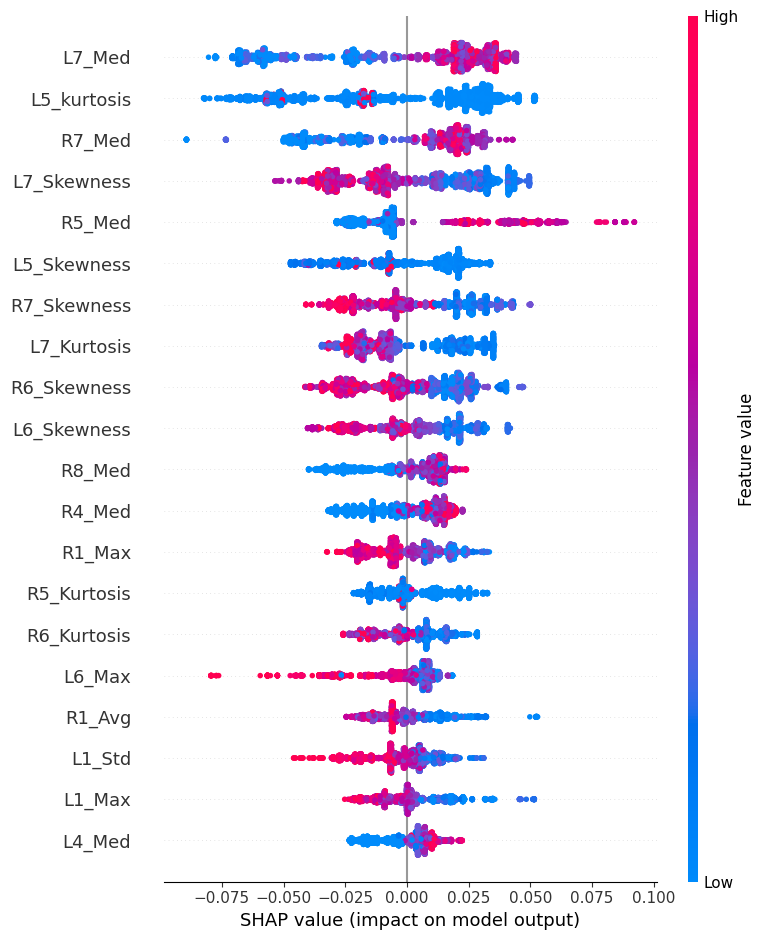

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rfc.rf_classifier)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test)

In [ ]:
rfc = RFClassifier(models_path,100,2)
# ccs=rfc.multiple_training([5, 10, 20, 40, 100, 200],2, X_train, y_train, X_test,  y_test )
rfc.taining( X_train, y_train)
perm = PermutationImportance(rfc.rf_classifier, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

invalid value encountered in double_scalars


Weight,Feature
0 ± 0.0000,L6_Avg
0 ± 0.0000,L2_Med
0 ± 0.0000,L2_Avg
0 ± 0.0000,L2_Skewness
0 ± 0.0000,L2_Kurtosis
0 ± 0.0000,L3_Max
0 ± 0.0000,L3_Std
0 ± 0.0000,L3_Med
0 ± 0.0000,L3_Avg
0 ± 0.0000,L3_Skewness


## RFC (6 features) then Interpretation

In [ ]:
for col in data.scaled_stances_statics_df.columns:
  print(col)

In [81]:
statics=[]
for col in data.cols_names[1:]:
  for x in ['_Min', '_Std', '_Med','_Avg','_Skewness','_Kurtosis']:
    statics.append((col+''+x))

signal_cols= np.append( signal_cols, statics)

In [82]:
df = data.scaled_stances_statics_df.drop(signal_cols,axis=1)
y = data.scaled_stances_statics_df[[ 'y']]

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

In [83]:
# Checking which RFC will work the best
rfc = RFClassifier(models_path,200,2)
ccs=rfc.multiple_training([5, 10, 20, 40, 100, 200],2, X_train, y_train, X_test,  y_test )

Estimator = 5
Accuracy: 0.9386, Precision: 0.9383, Recall: 0.9735, F1: 0.9556
Estimator = 10
Accuracy: 0.9544, Precision: 0.9546, Recall: 0.9793, F1: 0.9668
Estimator = 20
Accuracy: 0.9603, Precision: 0.9541, Recall: 0.9890, F1: 0.9713
Estimator = 40
Accuracy: 0.9612, Precision: 0.9531, Recall: 0.9916, F1: 0.9720
Estimator = 100
Accuracy: 0.9627, Precision: 0.9540, Recall: 0.9929, F1: 0.9731
Estimator = 200
Accuracy: 0.9638, Precision: 0.9547, Recall: 0.9939, F1: 0.9739


In [84]:
perm = PermutationImportance(ccs[5], random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=30)

Weight,Feature
0.0318 ± 0.0039,l_peaks_heel
0.0243 ± 0.0050,r_peaks_heel
0.0156 ± 0.0020,L6_fwhm
0.0135 ± 0.0022,l_max_peak
0.0115 ± 0.0030,r_swings_time
0.0099 ± 0.0018,R6_fwhm
0.0094 ± 0.0023,L5_fwhm
0.0086 ± 0.0024,l_swings_time
0.0051 ± 0.0013,l_peaks_toe
0.0048 ± 0.0018,R5_fwhm


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


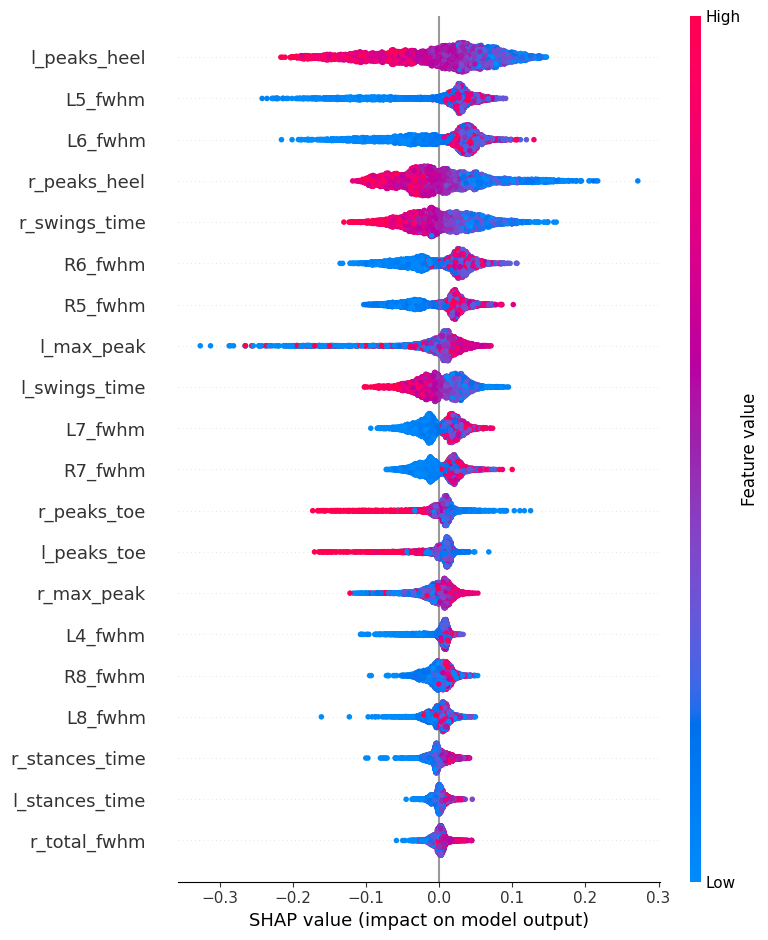

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(ccs[5])

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test)

In [ ]:
(X_test.columns)

Index(['l_strides_time', 'l_swings_time', 'l_stances_time', 'l_peaks_heel',
       'l_peaks_toe', 'r_strides_time', 'r_swings_time', 'r_stances_time',
       'r_peaks_heel', 'r_peaks_toe', 'l_max_peak', 'r_max_peak',
       'l_total_fwhm', 'r_total_fwhm', 'L1_fwhm', 'L2_fwhm', 'L3_fwhm',
       'L4_fwhm', 'L5_fwhm', 'L6_fwhm', 'L7_fwhm', 'L8_fwhm', 'R1_fwhm',
       'R2_fwhm', 'R3_fwhm', 'R4_fwhm', 'R5_fwhm', 'R6_fwhm', 'R7_fwhm',
       'R8_fwhm'],
      dtype='object')

## RFC Multiclass classification (statics with extracted features) then Interpretation


In [ ]:
for col in X_train_m.columns:
  print(col)

In [63]:
# Checking which RFC will work the best
rfc_m = RFClassifier(models_path,200,2,'micro')
ccs=rfc_m.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_m, y_train_m, X_test_m,  y_test_m )

Estimator = 5
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 10
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 20
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 40
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 100
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 200
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


In [66]:
perm = PermutationImportance(ccs[0], random_state=1).fit(X_test_m, y_test_m)
eli5.show_weights(perm, feature_names = X_test_m.columns.tolist())

Weight,Feature
0.0452 ± 0.0042,L7_Med
0.0196 ± 0.0023,R5_Med
0.0087 ± 0.0027,L6_Skewness
0.0029 ± 0.0012,R6_Kurtosis
0.0011 ± 0.0003,L8_Med
0.0011 ± 0.0006,R4_Skewness
0.0006 ± 0.0004,L5_Max
0.0005 ± 0.0006,R3_Skewness
0 ± 0.0000,L3_Avg
0 ± 0.0000,L3_Med


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


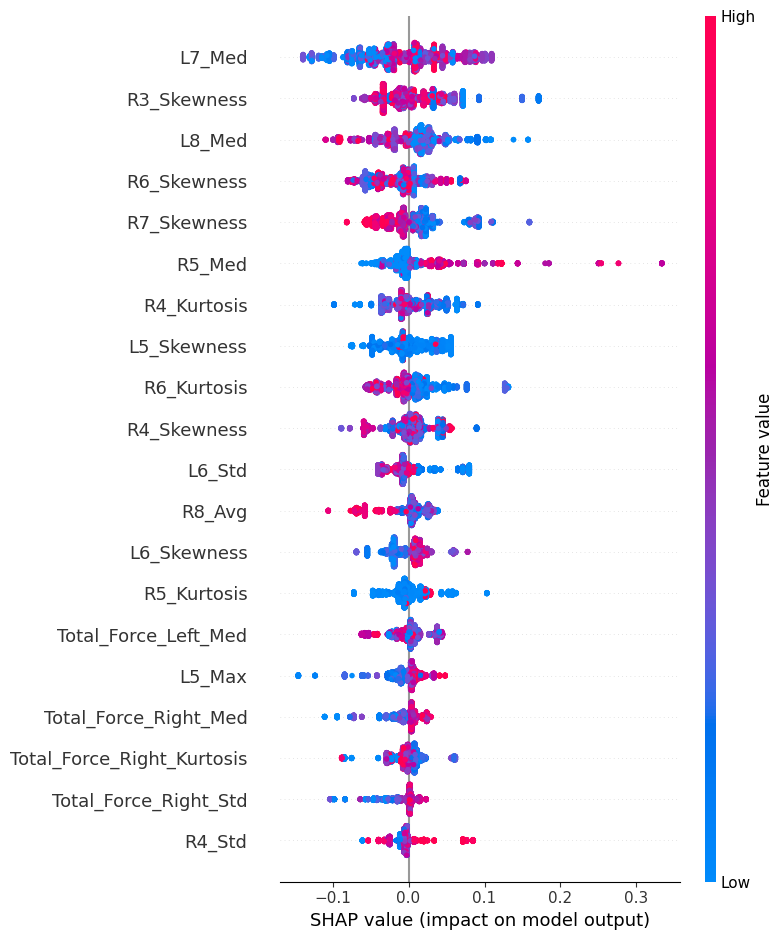

In [67]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(ccs[0])

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test_m)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test_m)

## RFC Multiclass classification with extracted features

In [68]:
statics=[]
for col in data.cols_names[1:]:
  for x in ['_Min', '_Std', '_Med','_Avg','_Skewness','_Kurtosis']:
    statics.append((col+''+x))

signal_cols= np.append( signal_cols, statics)

In [69]:
df = data.scaled_stances_statics_df.drop(signal_cols,axis=1)
y = data.scaled_stances_statics_df[[ 'level']]

y['level'].replace(3, 4, inplace= True)
     

y['level'].replace(2.5, 3, inplace= True)
     

y_m=y['level'].astype('int')
     


# splitting the data
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [71]:
for col in df.columns:
  print(col)

l_strides_time
l_swings_time
l_stances_time
l_peaks_heel
l_peaks_toe
r_strides_time
r_swings_time
r_stances_time
r_peaks_heel
r_peaks_toe
l_max_peak
r_max_peak
l_total_fwhm
r_total_fwhm
L1_fwhm
L2_fwhm
L3_fwhm
L4_fwhm
L5_fwhm
L6_fwhm
L7_fwhm
L8_fwhm
R1_fwhm
R2_fwhm
R3_fwhm
R4_fwhm
R5_fwhm
R6_fwhm
R7_fwhm
R8_fwhm


In [73]:
# Checking which RFC will work the best
rfc_m = RFClassifier(models_path,200,2,'micro')
ccs=rfc_m.multiple_training([5, 10, 20, 40, 100, 200],2, X_train, y_train, X_test,  y_test )

Estimator = 5
Accuracy: 0.8776, Precision: 0.8776, Recall: 0.8776, F1: 0.8776
Estimator = 10
Accuracy: 0.9081, Precision: 0.9081, Recall: 0.9081, F1: 0.9081
Estimator = 20
Accuracy: 0.9206, Precision: 0.9206, Recall: 0.9206, F1: 0.9206
Estimator = 40
Accuracy: 0.9320, Precision: 0.9320, Recall: 0.9320, F1: 0.9320
Estimator = 100
Accuracy: 0.9359, Precision: 0.9359, Recall: 0.9359, F1: 0.9359
Estimator = 200
Accuracy: 0.9392, Precision: 0.9392, Recall: 0.9392, F1: 0.9392


In [76]:
perm = PermutationImportance(ccs[5], random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=30)

Weight,Feature
0.0276 ± 0.0030,l_peaks_heel
0.0220 ± 0.0031,r_peaks_toe
0.0220 ± 0.0029,r_peaks_heel
0.0181 ± 0.0034,l_peaks_toe
0.0168 ± 0.0010,l_max_peak
0.0124 ± 0.0024,r_max_peak
0.0101 ± 0.0038,L6_fwhm
0.0092 ± 0.0015,R6_fwhm
0.0075 ± 0.0034,L5_fwhm
0.0072 ± 0.0018,r_swings_time


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


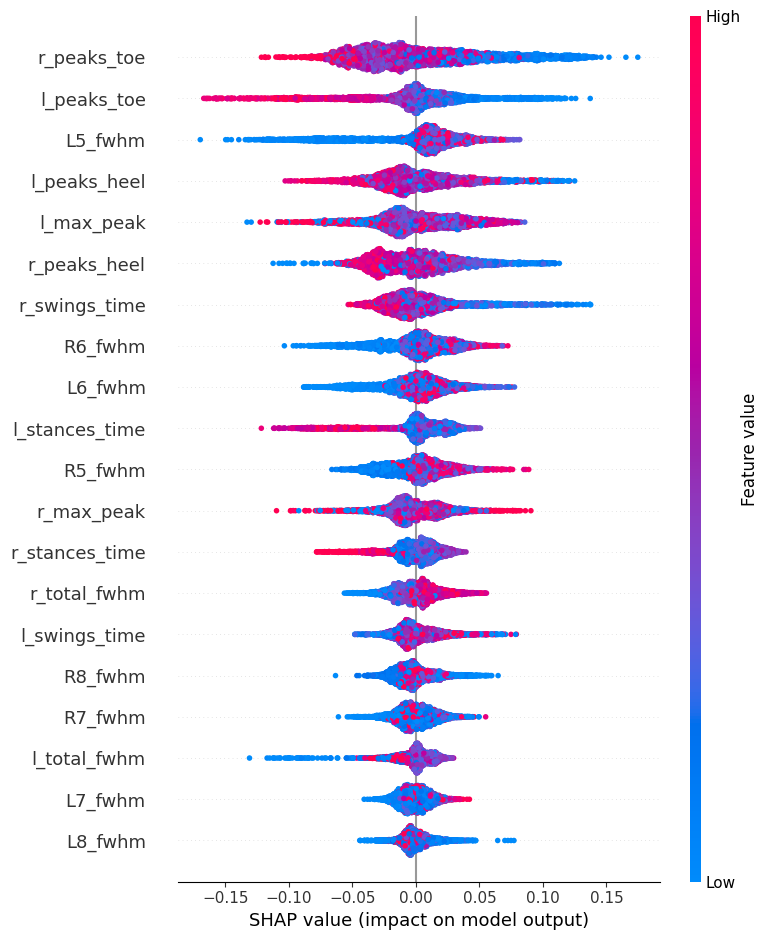

In [78]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(ccs[5])

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test)